In [2]:
import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, TensorDataset
import warnings
import matplotlib.pyplot as plt
import torch
from sklearn import metrics
import time
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce GTX 1070 Ti


In [4]:
train_data = pd.read_csv('train.csv',index_col='id')
pre_data = train_data

In [5]:
train_data.isnull().sum(axis = 0)

MO HLADR+ MFI (cells/ul)    1
Neu CD64+MFI (cells/ul)     1
CD3+T (cells/ul)            0
CD8+T (cells/ul)            0
CD4+T (cells/ul)            0
NK (cells/ul)               0
CD19+ (cells/ul)            0
CD45+ (cells/ul)            0
Age                         0
Sex 0M1F                    0
Mono CD64+MFI (cells/ul)    1
label                       0
dtype: int64

In [6]:
#fill nan value with mean
pre_data = pre_data.fillna(value={"MO HLADR+ MFI (cells/ul)": pre_data["MO HLADR+ MFI (cells/ul)"].mean(), 
                                              "Neu CD64+MFI (cells/ul)": pre_data["Neu CD64+MFI (cells/ul)"].mean(), 
                                              "Mono CD64+MFI (cells/ul)":pre_data["Mono CD64+MFI (cells/ul)"].mean()})


In [7]:
#normalize the data
pre_data.iloc[:,0:9] = pre_data.iloc[:,0:9].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
pre_data.iloc[:,-2] = (pre_data.iloc[:,-2] -pre_data.iloc[:,-2] .mean())/pre_data.iloc[:,-2] .std()

In [8]:
train, val = train_test_split(pre_data, test_size=0.2)
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
val_x = val.iloc[:,:-1]
val_y = val.iloc[:,-1]

In [11]:
xgboostModel = XGBClassifier(n_estimators=5000, learning_rate= 0.3, tree_method='gpu_hist')
xgboostModel.fit(train_x, train_y)
result = xgboostModel.predict(val_x)
print(accuracy_score(val_y, result))
print(confusion_matrix(val_y, result))
print(classification_report(val_y, result))

H:\ProgramData\Anaconda3\envs\test1\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7777777777777778
[[10  2]
 [ 2  4]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.67      0.67      0.67         6

    accuracy                           0.78        18
   macro avg       0.75      0.75      0.75        18
weighted avg       0.78      0.78      0.78        18



In [33]:
# save the model
xgboostModel.save_model("xg_model.pth")

# NN

In [12]:
# define function for creating dataloader on training set and validation set
def create_dataloader(input_x, input_y):
    #Create tensor for features and labels
    features = torch.tensor(input_x, dtype=torch.float) 
    labels = torch.tensor(input_y,dtype=torch.long) 

    #Create tensor dataset
    data = TensorDataset(features, labels) 

    # Split into Training and Validatation sets using random_split 
    train_batch_size = 1      
    number_rows = len(features)
    val_split = int(number_rows*0.1) 
    train_split = number_rows - val_split     
    train_set, val_set = random_split(data, [train_split, val_split])    

    # Create Dataloader
    train_loader = DataLoader(train_set, batch_size = train_batch_size, shuffle = True) 
    val_loader = DataLoader(val_set, batch_size = 1)
    return train_loader, val_loader

In [13]:
#build model for binary classification
class myBinaryModel(nn.Module):
    def __init__(self, in_dim):
        super(myBinaryModel, self).__init__()
        self.fc1 = nn.Linear(in_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        self.m = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.m(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [14]:
# define a function for model training
def train(model, num_epoch,model_name):
    top_accuracy = 0.0 
    train_epoch_loss= []
    val_epoch_acc= []
    val_epoch_loss= []
    
    for epoch in range(1,num_epoch):
        training_loss = 0.0 
        val_loss = 0.0
        val_accuracy =0.0
        length = 0 
        
        for data in train_loader: 
            model.train()
            x, y = tuple(t.to(device) for t in data)
            # reset the gradients
            optimizer.zero_grad()
            # feedforward
            logits = model(x)
            # calcualte the cross-entropy loss 
            loss = loss_function(logits, y)
            # backprop
            loss.backward()
            # perform a single optimization step
            optimizer.step()
            #store the tempoary loss
            training_loss+=loss.item()
        #store the loss in each epoch
        train_epoch_loss.append(training_loss/len(train_loader))
       
        
        with torch.no_grad(): 
            model.eval() 
            for data in val_loader: 
                x, y = tuple(t.to(device) for t in data)
                logits = model(x)
                loss = loss_function(logits, y)
                #store the tempoary loss and accuracy
                val_loss +=loss.item()
                length += logits.size(0)
                val_accuracy += (y==torch.max(logits, 1)[1]).sum().item()       
        #store the loss and accuracy in each epoch
        val_epoch_loss.append(val_loss/len(val_loader))
        accuracy = 100*val_accuracy/length
        val_epoch_acc.append(accuracy)
        if accuracy >= top_accuracy:
            top_accuracy = accuracy
            path = "./"+ model_name + ".pth" 
            torch.save(model.state_dict(), path)

    return num_epoch,train_epoch_loss, val_epoch_acc, top_accuracy

In [15]:
# define a function for testing the model
def predict(model, x_test):
    # set evaluation mode
    model.eval()
    with torch.no_grad(): 
        x = torch.tensor(x_test, dtype=torch.float).to(device)
        
        logits = model(x)
        predict_y = torch.max(logits.data, 1)[1]
    return predict_y

# Cross_validation Training

-----------------------------------------------------------------
Start to use training dataset to train model
87.5


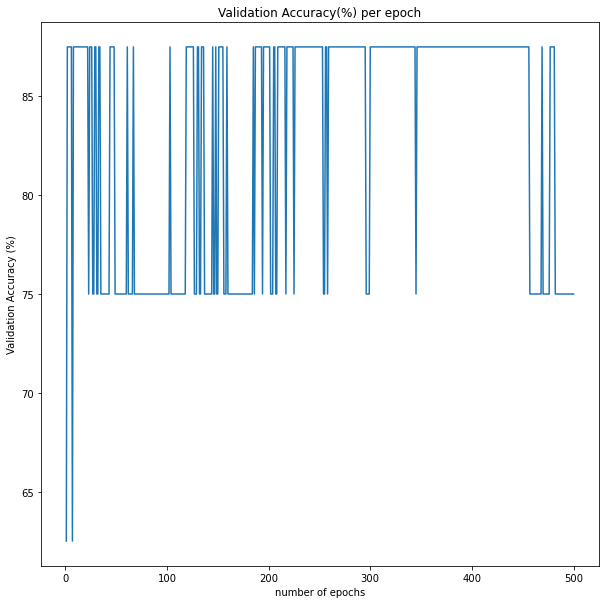

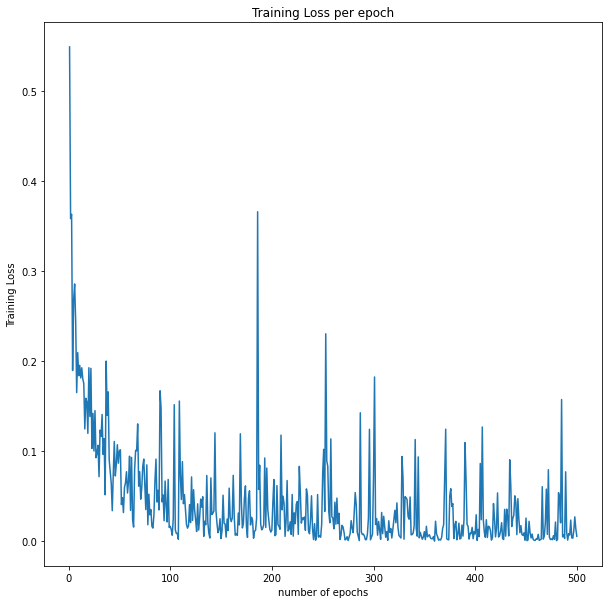

In [14]:
# start training and validation
print('-----------------------------------------------------------------')
print('Start to use training dataset to train model')
train_x = pre_data.iloc[:,:-1]
train_y = pre_data.iloc[:,-1]
train_loader, val_loader = create_dataloader(train_x.values, train_y.values)
#Parameters setup
learning_rate = 0.003
num_features = train_x.shape[1]

#setup model
model = myBinaryModel(num_features)
model.to(device)

#setup SGD as optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#setup CrossEntropyLoss as loss function
loss_function = nn.CrossEntropyLoss()
warnings.filterwarnings("ignore")
        
num_epoch,epoch_loss, epoch_acc, top_acc = train(model, 501, 'final_model')

#print out the average top accuracy and plot the graph on different number of hidden unit
print(top_acc)
title = 'Validation Accuracy(%) per epoch'
xlabel = 'number of epochs'
ylabel = 'Validation Accuracy (%)'
x = np.linspace(1, num_epoch-1, num_epoch-1)
plt.figure(figsize=(10,10))
plt.plot(x, epoch_acc)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.show()
    
title = 'Training Loss per epoch'
xlabel = 'number of epochs'
ylabel = 'Training Loss'
plt.figure(figsize=(10,10))
plt.plot(x, epoch_loss)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.show()

# 5 fold training

0
save model
save model
100.0


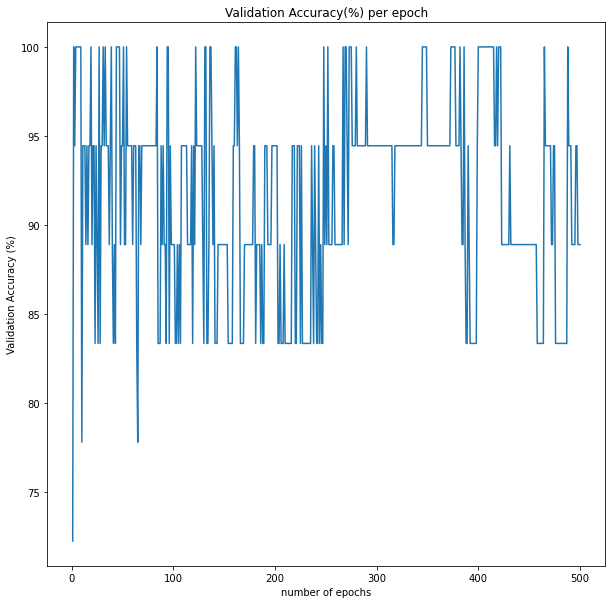

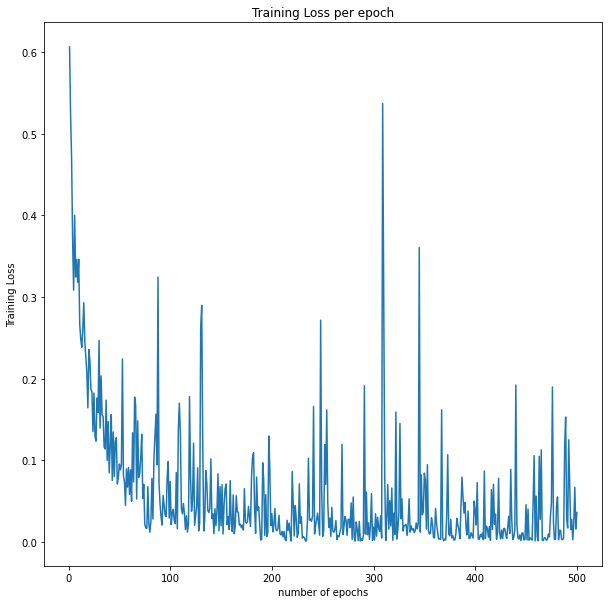

1
save model
save model
94.44444444444444


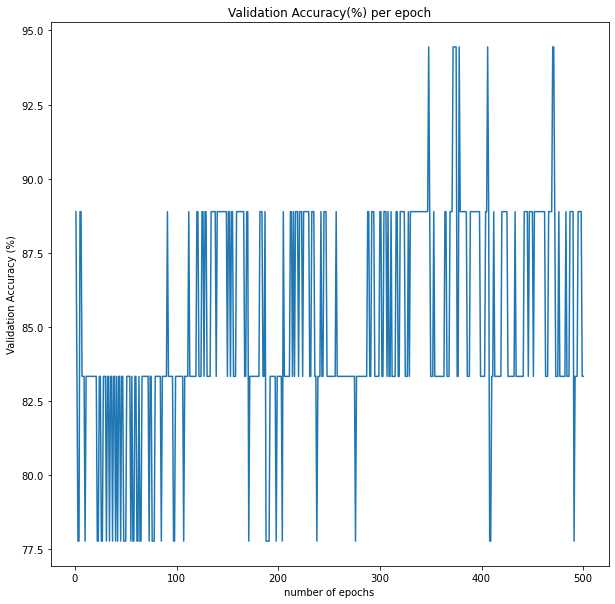

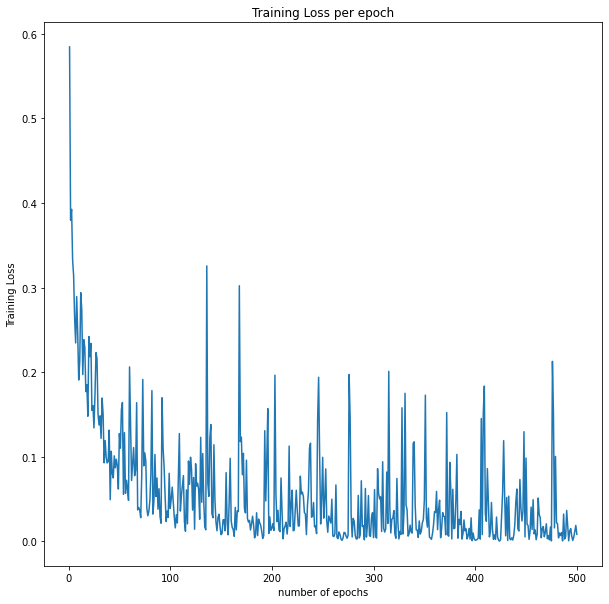

2
save model
save model
save model
88.23529411764706


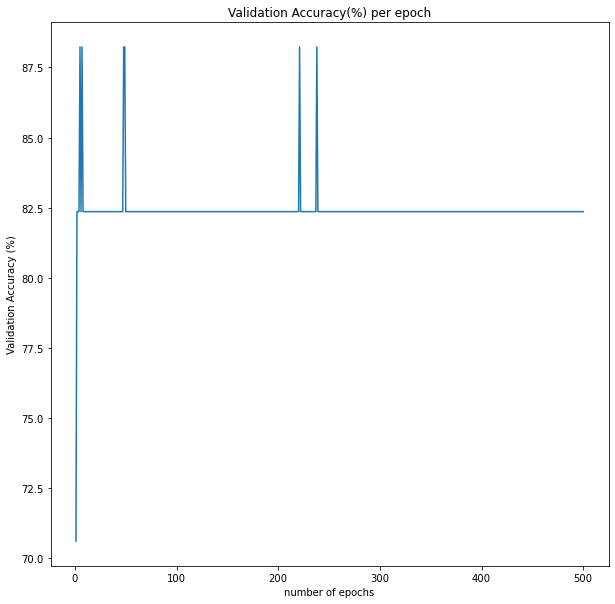

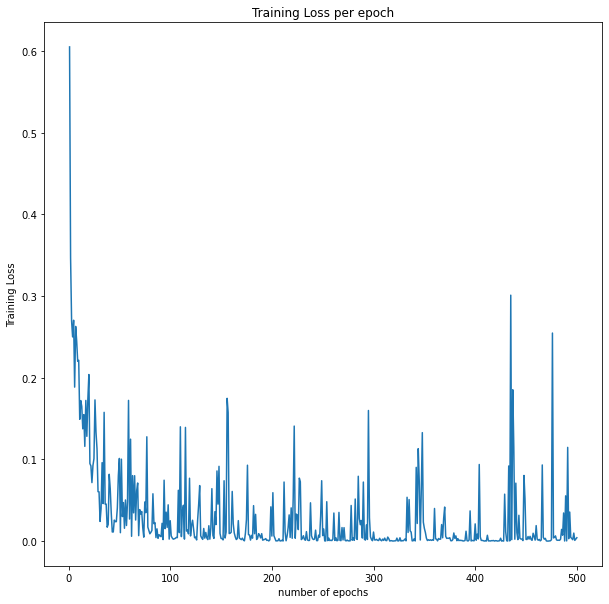

3
save model
save model
94.11764705882354


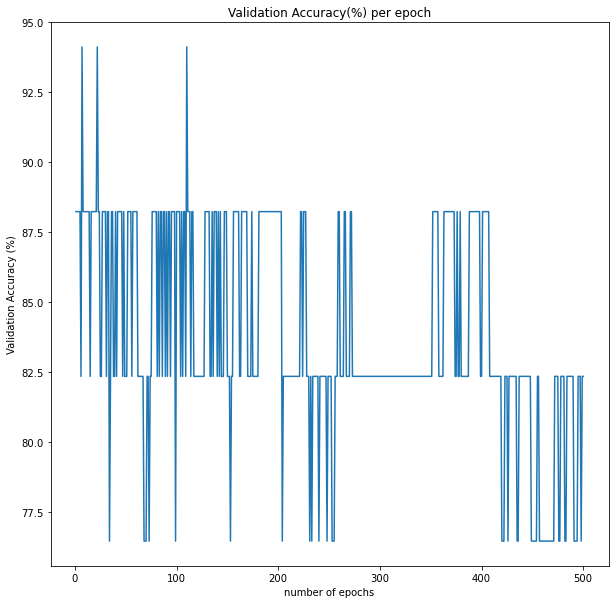

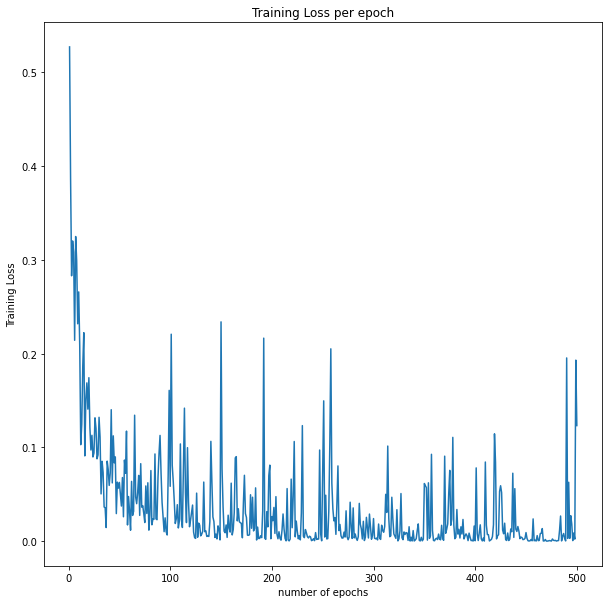

4
save model
save model
save model
88.23529411764706


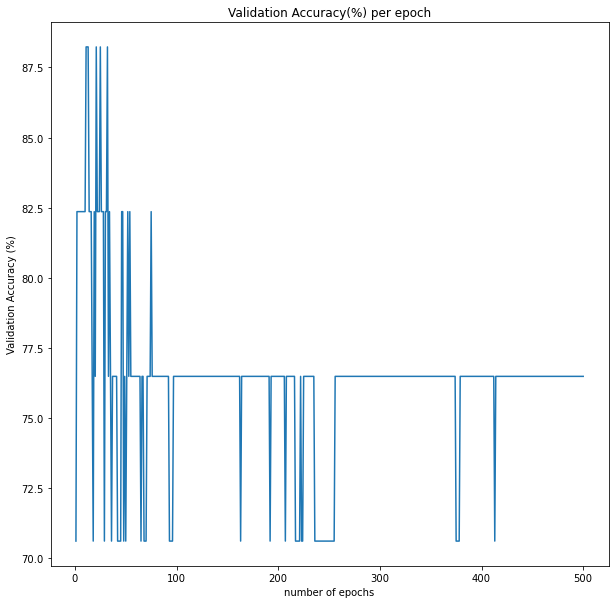

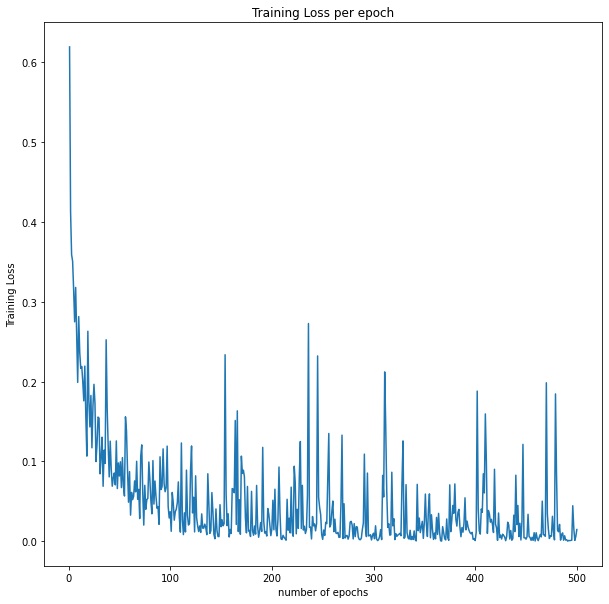

In [18]:
train_x = pre_data.iloc[:,:-1]
train_y = pre_data.iloc[:,-1]

features = torch.tensor(train_x.values, dtype=torch.float) 
labels = torch.tensor(train_y.values,dtype=torch.long) 

#Create tensor dataset
dataset = TensorDataset(features, labels)


kf = KFold(n_splits=5,shuffle=True)

for fold, (train_set, val_set) in enumerate(kf.split(dataset)):
    top_accuracy = 0.0 

    print(fold)
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_set)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_set)
    
    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=val_subsampler)
    #Parameters setup
    learning_rate = 0.003
    num_features = train_x.shape[1]

    #setup model
    model = myBinaryModel(num_features)
    model.to(device)

    #setup SGD as optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #setup CrossEntropyLoss as loss function
    loss_function = nn.CrossEntropyLoss()
    warnings.filterwarnings("ignore")

    
    train_epoch_loss= []
    val_epoch_acc= []
    val_epoch_loss= []
    num_epoch = 501
    for epoch in range(1,num_epoch):
        training_loss = 0.0 
        val_loss = 0.0
        val_accuracy =0.0
        length = 0 
        
        for data in train_loader: 
            model.train()
            x, y = tuple(t.to(device) for t in data)
            # reset the gradients
            optimizer.zero_grad()
            # feedforward
            logits = model(x)
            # calcualte the cross-entropy loss 
            loss = loss_function(logits, y)
            # backprop
            loss.backward()
            # perform a single optimization step
            optimizer.step()
            #store the tempoary loss
            training_loss+=loss.item()
        #store the loss in each epoch
        train_epoch_loss.append(training_loss/len(train_loader))
       
        
        with torch.no_grad(): 
            model.eval() 
            for data in val_loader: 
                x, y = tuple(t.to(device) for t in data)
                logits = model(x)
                loss = loss_function(logits, y)
                #store the tempoary loss and accuracy
                val_loss +=loss.item()
                length += logits.size(0)
                val_accuracy += (y==torch.max(logits, 1)[1]).sum().item()       
        #store the loss and accuracy in each epoch
        val_epoch_loss.append(val_loss/len(val_loader))
        accuracy = 100*val_accuracy/length
        val_epoch_acc.append(accuracy)
        if accuracy > top_accuracy:
            top_accuracy = accuracy
            torch.save(model.state_dict(), f'fold_{fold}_model.pth')
            print('save model')
    print(top_accuracy)
    title = 'Validation Accuracy(%) per epoch'
    xlabel = 'number of epochs'
    ylabel = 'Validation Accuracy (%)'
    x = np.linspace(1, num_epoch-1, num_epoch-1)
    plt.figure(figsize=(10,10))
    plt.plot(x, val_epoch_acc)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

    title = 'Training Loss per epoch'
    xlabel = 'number of epochs'
    ylabel = 'Training Loss'
    plt.figure(figsize=(10,10))
    plt.plot(x, train_epoch_loss)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# use all data to train

In [16]:
# define a function for final model training using full set of training data
def final_model_train(model, num_epoch, model_name):
    top_accuracy = 0.0 
    train_epoch_loss= []
    train_epoch_acc = []
    for epoch in range(1,num_epoch):
        training_loss = 0.0 
        training_accuracy = 0.0
        length = 0
        
        for data in train_loader: 
            model.train()
            x, y = tuple(t.to(device) for t in data)
            # reset the gradients
            optimizer.zero_grad()
            # feedforward
            logits = model(x)
            # calcualte the cross-entropy loss 
            loss = loss_function(logits, y)
            # backprop
            loss.backward()
            # perform a single optimization step
            optimizer.step()
            #store the tempoary loss and accuracy
            training_loss+=loss.item()
            length += logits.size(0)
            training_accuracy += (y==torch.max(logits, 1)[1]).sum().item()   
        #store the loss and accuracy in each epoch
        train_epoch_loss.append(training_loss/len(train_loader))
        accuracy = 100*training_accuracy/length
        train_epoch_acc.append(accuracy)
        
        if accuracy > top_accuracy:
            top_accuracy = accuracy
            path = "./"+ model_name + ".pth" 
            torch.save(model.state_dict(), path) 
        

        if epoch%5==0:
            print("Training Accuracy(AUC)(%): {}".format(accuracy))
            
    return num_epoch, train_epoch_acc, train_epoch_loss, top_accuracy

Training Accuracy(AUC)(%): 89.85507246376811
Training Accuracy(AUC)(%): 89.85507246376811
Training Accuracy(AUC)(%): 95.65217391304348
Training Accuracy(AUC)(%): 79.71014492753623
Training Accuracy(AUC)(%): 89.85507246376811
Training Accuracy(AUC)(%): 92.7536231884058
Training Accuracy(AUC)(%): 94.20289855072464
Training Accuracy(AUC)(%): 91.30434782608695
Training Accuracy(AUC)(%): 92.7536231884058
Training Accuracy(AUC)(%): 97.10144927536231
Training Accuracy(AUC)(%): 95.65217391304348
Training Accuracy(AUC)(%): 94.20289855072464
Training Accuracy(AUC)(%): 94.20289855072464
Training Accuracy(AUC)(%): 95.65217391304348
Training Accuracy(AUC)(%): 97.10144927536231
Training Accuracy(AUC)(%): 94.20289855072464
Training Accuracy(AUC)(%): 95.65217391304348
Training Accuracy(AUC)(%): 95.65217391304348
Training Accuracy(AUC)(%): 97.10144927536231
Training Accuracy(AUC)(%): 95.65217391304348
Model Accuracy (%) = 98.55072463768116


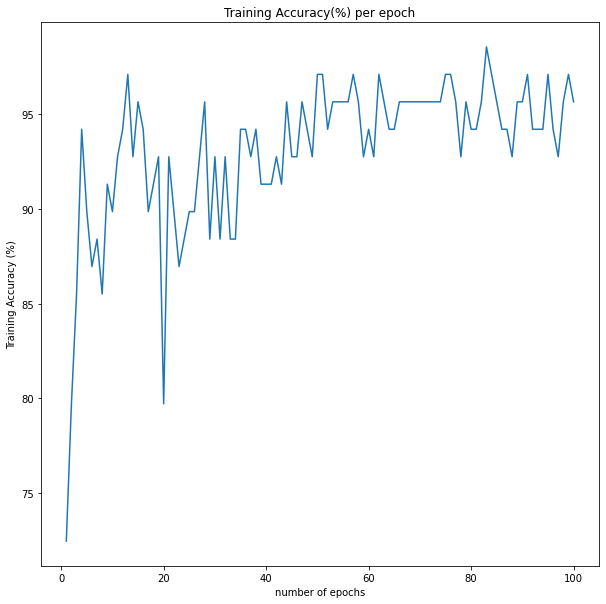

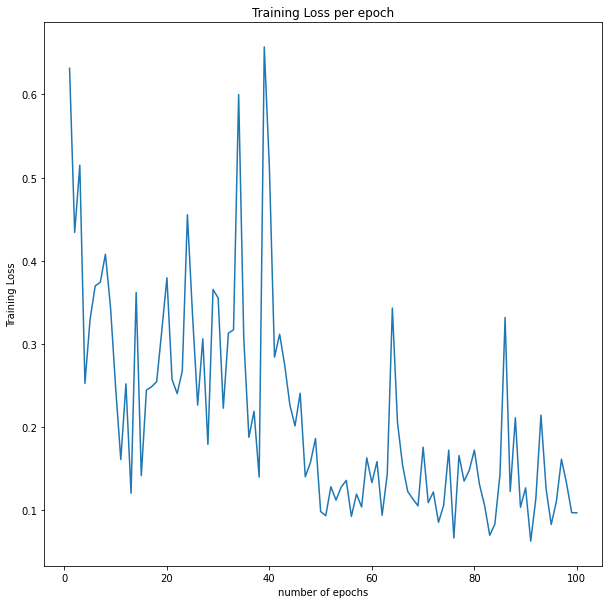

In [18]:
# start training model using all train data 
#Create tensor for features and labels
features = torch.tensor(train_x.values, dtype=torch.float)
labels = torch.tensor(train_y.values,dtype=torch.long)
#Create tensor dataset
train_set = TensorDataset(features, labels)
train_batch_size = 5       
# Create Dataloader
train_loader = DataLoader(train_set, batch_size = train_batch_size, shuffle = True)

#Parameters setup
learning_rate = 0.03
num_features = train_x.shape[1]

#setup model
model = myBinaryModel(num_features)
model.to(device)

#setup SGD as optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#setup CrossEntropyLoss as loss function
loss_function = nn.CrossEntropyLoss()
warnings.filterwarnings("ignore")
        
#start to train and store the result for this round
num_epoch, epoch_acc, epoch_loss, top_acc = final_model_train(model, 101,'final_model2')
#print out the accuracy
print('Model Accuracy (%) = ' + str(top_acc))

#plot the graph on Accuracy and Loss
title = 'Training Accuracy(%) per epoch'
xlabel = 'number of epochs'
ylabel = 'Training Accuracy (%)'
x = np.linspace(1, num_epoch-1, num_epoch-1)
plt.figure(figsize=(10,10))
plt.plot(x, epoch_acc)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.show()
    
title = 'Training Loss per epoch'
xlabel = 'number of epochs'
ylabel = 'Training Loss'
plt.figure(figsize=(10,10))
plt.plot(x, epoch_loss)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.show()


# Generate result using Test data

In [20]:
#Pre-processing
test_data = pd.read_csv('test.csv',index_col='id')
#normalize the data
test_data.iloc[:,0:9] = test_data.iloc[:,0:9].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
test_data.iloc[:,-1] = (test_data.iloc[:,-1] -test_data.iloc[:,-1] .mean())/test_data.iloc[:,-1] .std()

## K-fold result

In [48]:
filename = '5_fold_avg'
result = np.zeros(59)
for fold in range(5):
    model = myBinaryModel(num_features)
    model.load_state_dict(torch.load(f'fold_{fold}_model.pth'))   
    model.to(device)
    result+=np.array(predict(model,test_data.values).cpu())/5

In [49]:
result = np.where(result > 0.5, 1, 0)

## other

In [23]:
filename = 'full_model'
model = myBinaryModel(num_features)
model.load_state_dict(torch.load('final_model2.pth'))   
model.to(device)
result = np.array(predict(model,test_data.values).cpu())

In [24]:
final_result = test_data
final_result['label'] = result

In [25]:
final_result = final_result['label']

In [26]:
pd.DataFrame(final_result).to_csv(f'{filename}.csv', index=True, header=True)